This tutorial shows how to build a language translation model in the architecture of the Transformer.
The main framework we are going to use is ReNom, and this Transformer model will be able to translate sentences from Portuguese to English.
This is an advanced example so I assume that you have basic understandings about the Transformer model and the Attention mechanism. 

<h2> Libraries </h2>

As mentioned, our main framework for building model is ReNom (version >= 3.0).

We will also use some utility functions provided in tensorflow (version >= 2.0).

In [3]:
import renom as rm
import renom.graph as rmg
import numpy as np
from tensorflow.keras.utils import to_categorical #For one-hot encoding
import tensorflow_datasets as tfds #For the tokenizer
import matplotlib.pyplot as plt
rm.set_cuda_active(rm.has_cuda()) #Active GPUs if available

<h2> Data source </h2>

Datasets for Portuguese and English can be found at: https://github.com/neulab/word-embeddings-for-nmt.[2]

> wget http://www.phontron.com/data/qi18naacl-dataset.tar.gz

This dataset contains 51786 training examples, 1194 validation examples, and 1804 test examples.

All the files can be read as normal string file.

In [1]:
root_path = "datasets/pt_to_en/"
file_names = ["en.train", "en.test", "en.dev", "pt.train", "pt.test", "pt.dev"]
raw_data = dict()
for file_name in file_names:
    with open(root_path + file_name, "r", encoding = "utf-8") as f:
        raw_string = f.read()
        raw_data[file_name] = raw_string.split("\n")
        
for key, val in raw_data.items():
    print("Number of sequence in " + key + " :", len(val))

Number of sequence in en.train : 51786
Number of sequence in en.test : 1804
Number of sequence in en.dev : 1194
Number of sequence in pt.train : 51786
Number of sequence in pt.test : 1804
Number of sequence in pt.dev : 1194


<h2> Train tokenizers </h2>

Create a custom subwords tokenizer from the training dataset by using tensorflow's tokenizer.

The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [4]:
#Tokenizer for English
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (val for val in raw_data["en.train"]),
    target_vocab_size=2**13)
#Tokenizer for Portuguese
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (val for val in raw_data["pt.train"]),
    target_vocab_size=2**13)

sample_string_en = "Nice to meet you"
sample_string_pt = "Muito prazer em conhecêlo"

def test_tokenizer(sample_string, tokenizer):
    print ("Sample string  :", sample_string)
    encoded_string = tokenizer.encode(sample_string)
    print ("Encoded string :", encoded_string)
    decoded_string = tokenizer.decode(encoded_string)
    print ("Decoded string :", decoded_string)
    assert decoded_string == sample_string
    
test_tokenizer(sample_string_en, tokenizer_en)
print("=============================="*2)
test_tokenizer(sample_string_pt, tokenizer_pt)

Sample string  : Nice to meet you
Encoded string : [7909, 2541, 5, 1174, 51]
Decoded string : Nice to meet you
Sample string  : Muito prazer em conhecêlo
Encoded string : [8035, 1461, 389, 5176, 14, 7884, 7434, 232]
Decoded string : Muito prazer em conhecêlo


<h2> Data preprocessing </h2>

Bellow are a few preprocessing steps for the string data that we read ealier:
<ul>
<li>Encode each sentence into list of tokens by using the above tokenizers.</li>
<li>Add tokens for indicating the beginning and ending of sentence.</li>
<li>Filter all too long sentences (to keep this example small and be able to train fast).</li>
<li>Add padding tokens</li>
</ul>
For training, the Transformer needs 3 datasets:
<ul>
<li>Portuguese data as input (w/ both beginning and ending tokens).</li>
<li>English data as input (w/ only beginning and no ending tokens).</li>
<li>English data as target for computing loss (w/ only ending token and no beginning tokens).</li>
</ul>

In [5]:
#All the sentences containing more than 40 tokens will be eliminated
#All the sentences shorter than 40 tokens will be padded to the length of 40
MAX_SEQ_LEN = 40 

tokenized_data = dict()
start_token_en = [tokenizer_en.vocab_size] #Token indicating the beginning of a English sentence
end_token_en = [tokenizer_en.vocab_size + 1] #Token indicating the ending of a Portuguese sentence
start_token_pt = [tokenizer_pt.vocab_size] #Token indicating the beginning of a English sentence
end_token_pt = [tokenizer_pt.vocab_size + 1] #Token indicating the ending of a Portuguese sentence

for en, pt in [["en.train", "pt.train"], ["en.test", "pt.test"], ["en.dev", "pt.dev"]]:
    token_en_inp, token_en_tar = list(), list()
    for text in raw_data[en]:
        encoded = tokenizer_en.encode(text)
        token_en_inp.append(start_token_en + encoded)
        token_en_tar.append(encoded + end_token_en)
    token_pt = [start_token_pt + tokenizer_pt.encode(text) + end_token_pt for text in raw_data[pt]]
    
    token_en_inp_filtered, token_en_tar_filtered, token_pt_filtered = list(), list(), list()
    for tok_seq_en_inp, tok_seq_en_tar, tok_seq_pt in zip(token_en_inp, token_en_tar, token_pt):
        if len(tok_seq_en_inp)<=MAX_SEQ_LEN and len(tok_seq_en_tar)<=MAX_SEQ_LEN and len(tok_seq_pt)<=MAX_SEQ_LEN:
            #Padding [0] tokens
            tok_seq_en_inp = tok_seq_en_inp + [0]*(MAX_SEQ_LEN - len(tok_seq_en_inp))
            tok_seq_en_tar = tok_seq_en_tar + [0]*(MAX_SEQ_LEN - len(tok_seq_en_tar))
            tok_seq_pt = tok_seq_pt + [0]*(MAX_SEQ_LEN - len(tok_seq_pt))
            token_en_inp_filtered.append(tok_seq_en_inp)
            token_en_tar_filtered.append(tok_seq_en_tar)
            token_pt_filtered.append(tok_seq_pt)
            
    tokenized_data[en + ".inp"] = token_en_inp_filtered
    tokenized_data[en + ".tar"] = token_en_tar_filtered
    tokenized_data[pt] = token_pt_filtered
    
for key, val in tokenized_data.items():
    print("Number of sequence in " + key + " :", len(val))

Number of sequence in en.train.inp : 45125
Number of sequence in en.train.tar : 45125
Number of sequence in pt.train : 45125
Number of sequence in en.test.inp : 1553
Number of sequence in en.test.tar : 1553
Number of sequence in pt.test : 1553
Number of sequence in en.dev.inp : 1078
Number of sequence in en.dev.tar : 1078
Number of sequence in pt.dev : 1078


In [7]:
for key, val in tokenized_data.items():
    flatten = list()
    for seq in val:
        for token in seq:
            flatten.append([token])
    tokenized_data[key] = np.asarray(flatten)
    
print(tokenized_data["en.train.inp"].shape)
print(tokenized_data["en.train.tar"].shape)
print(tokenized_data["pt.train"].shape)

(1805000, 1)
(1805000, 1)
(1805000, 1)


<h2> Position Encoding </h2>

As you may have known, the Transformer does not contain any recurrence or convolution. While processing sequential data, it is important to take the information about the relative position in to account. Hence we are introduced to the concept of position encoding.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space. [1]

<img src="images/position encoding transformer.png" align="middle" width="400"/>

The fomular for position encoding is as the photo bellow. If you are not familiar with this concept, please take a look as this tensorflow's notebook about position encoding: https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb

<img src="images/position encoding fomula.png" align="middle" width="350"/>

In [27]:
def get_position_encoding_matrix(num_position, d_model, min_rate = 1/10000):
    angle_rates = min_rate**(np.linspace(0, 1, d_model//2))
    positions = np.arange(num_position) 
    angle_rads = (positions[:, np.newaxis]) * angle_rates[np.newaxis, :]
    sines = np.sin(angle_rads)
    cosines = np.cos(angle_rads)
    pos_encoding = np.stack([sines, cosines],axis=2).reshape(sines.shape[0],-1)
    pos_encoding = pos_encoding[np.newaxis, ...]
    return pos_encoding, sines, cosines

NUM_POSITIONS = 1000
D_MODEl = 512
MIN_RATE = 1/10000
pos_encoding, sines, cosines = get_position_encoding_matrix(NUM_POSITIONS, D_MODEl, MIN_RATE)

Visualization for sine (left) and cosine (right) function

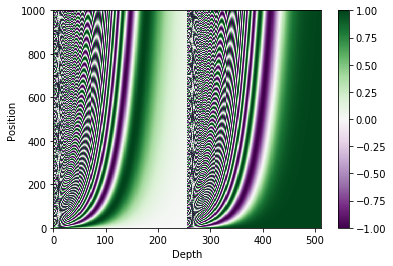

In [29]:
plt.pcolormesh(np.concatenate([sines, cosines], axis=-1), cmap='PRGn')
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()
plt.show()

Visualization for juxtaposed function

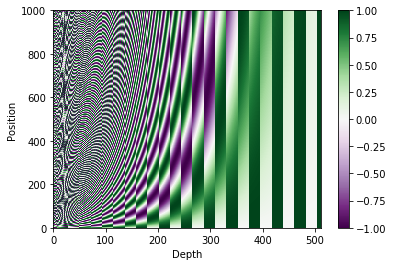

POSITION ENCODING SHAPE:  (1, 1000, 512)


In [31]:
plt.pcolormesh(pos_encoding[0], cmap='PRGn')
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()
plt.show()
print("POSITION ENCODING SHAPE: ", pos_encoding.shape)

<h2> Masking </h2>

There are 2 type of masks that we are going to use for the Transformer:
<ul>
    <li> Padding mask: to ensure that the model does not treat padding as the input. This mask outputs a 1 at all padding locations ([0] token), and a 0 otherwise.</li>
    <li> Look-ahead mask: to mask the future tokens in a sequence, indicates which tokens should and shoud not be used. For example, in order to predict the second word, only the first should be used. Similarly to predict the third word, only the first and second should be used and so on.</li>
</ul>


In [33]:
def create_padding_mask(seq):
    mapping_func = np.vectorize(lambda x: x == 0, otypes=[np.float32])
    mask = mapping_func(np.copy(seq))
    return mask

def create_look_ahead_mask(size):
    ones = np.ones((size, size), dtype=np.float32)
    look_ahead_mask = np.triu(ones, k=1)
    return look_ahead_mask 

In [35]:
x = np.asarray([[7, 6, 9, 0, 0, 0],
                [9, 7, 3, 1, 3, 0],
                [4, 8, 0, 0, 0, 0]])
create_padding_mask(x)

array([[0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 1.]], dtype=float32)

In [36]:
create_look_ahead_mask(6)

array([[0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

<h2> Scaled dot product attention </h2>


<img src="images/scaled dot product.png" align="middle" width="200"/>

The input consists of queries and keys of dimension dk , and values of dimension dv . We compute the dot products of the query with all keys, divide each by dk, and apply a softmax function to obtain the weights on the values. [1]


<img src="images/scaled dot product fomula.png" align="middle" width="350"/>

In [37]:
def scaled_dot_product_attention(self, 
                                 q, # (B*SQ, DEPTH)
                                 k, # (B*SK, DEPTH)
                                 v, # (B*SK, DEPTH)
                                 mask):
    matmul_qk = self.custom_matmul(q, k) #(B*SQ, SK)
    scaled_attention_logits = matmul_qk / np.sqrt(40) #Max sequence length here
    scaled_attention_logits += mask 
    scaled_attention = rmg.softmax(scaled_attention_logits)
    output =  self.custom_matmul(scaled_attention, v, transpose_b = False) #(B*SQ, DEPTH)
    return output

<h2> Multi-head Attention </h2>

Multi-head attention (MHA) consists of four parts:
<ul>
<li>Linear layers and split into heads.</li>
<li>Scaled dot-product attention.</li>
<li>Concatenation.</li>
<li>Final linear layer.</li>
</ul>

<img src="images/multi head attention.png" align="middle" width="250"/>  

Each MHA block will receive three inputs: Q (query), K (key), V (value). These are put through linear layers and split up into multiple heads, then perform scaled dot production attention. All the attention outputs of all heads are then concatenated and put through the final linear layer.

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. [1]

<img src="images/concat.png" align="middle" width="400"/>

In [3]:
class MultiHeadAttention(rmg.core.GraphFactory):
    def prepare(self, d_model, num_heads):
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        depth = d_model // num_heads
        self.dense_q, self.dense_k, self.dense_v = list(), list(), list()
        
        for layer in [self.dense_q, self.dense_k, self.dense_v]:
            for head_id in range(num_heads):
                layer.append(rmg.Dense(depth))
        self.dense_final = rmg.Dense(d_model)
    
    #Right now ReNom does not support batch matrix multiplication so we need to write a custom function for that
    def custom_matmul(self, a, b, max_seq_len = 40, transpose_b = True):
        mul = list()
        for i in range(int(a.shape[0])//max_seq_len):
            begin = i * max_seq_len
            end = begin + max_seq_len
            a_i = a[begin:end]
            b_i = b[begin:end]
            if transpose_b:
                b_i = b_i.T
            mul.append(a_i @ b_i)
        result = rmg.concatenate(mul)
        return result

    def scaled_dot_product_attention(self, 
                                     q, # (B*SQ, DEPTH)
                                     k, # (B*SK, DEPTH)
                                     v, # (B*SK, DEPTH)
                                     mask):
        matmul_qk = self.custom_matmul(q, k) #(B*SQ, SK)
        scaled_attention_logits = matmul_qk / np.sqrt(40) #Max sequence length here
        scaled_attention_logits += mask 
        scaled_attention = rmg.softmax(scaled_attention_logits)
        output =  self.custom_matmul(scaled_attention, v, transpose_b = False) #(B*SQ, DEPTH)
        return output
    
    def connect(self, 
                q, # (B*SQ, D_MODEL)
                k, # (B*SK, D_MODEL)
                v, # (B*SK, D_MODEL)
                mask):
        assert k.shape[0].value == v.shape[0].value
        head_summaries = list()
        
        for head_id in range(self.num_heads):
            out_q = self.dense_q[head_id](q) # (B*SQ, DEPTH)
            out_k = self.dense_k[head_id](k) # (B*SK, DEPTH)
            out_v = self.dense_v[head_id](v) # (B*SK, DEPTH)     
            head_attention_weights = self.scaled_dot_product_attention(out_q, out_k, out_v, mask)
            head_summaries.append(head_attention_weights) 
        
        concat_attention = rmg.concatenate(head_summaries, axis=1) # (B*SQ, D_MODEL)
        output = self.dense_final(concat_attention) # (B*SQ, D_MODEL)
        return output

<h2>Encoder/Decoder Layer</h2>

This photo bellows show the structure of one encoder layer (red box), and one decoder layer (black box).

<img src="images/encoder decoder cell.png" align="middle" width="400"/>

I call the 2 inside box an MHA_Cell (green box) and a FFN_Cell (blue box)

In [ ]:
class MHA_Cell(rmg.core.GraphFactory):
    def prepare(self, d_model, num_heads, dropout_rate):
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.dropout = rmg.Dropout(dropout_rate)
        self.layernorm = rmg.LayerNormalize()
        
    def connect(self, q, k, v, mask, inference):
        self.dropout.set_inference(inference)
        output = self.mha(q, k, v, mask)  # (B*SQ, D_MODEL)
        output = self.dropout(output)
        output = self.layernorm(q + output) #Residual connection
        return output

In [4]:
class FFN_Cell(rmg.core.GraphFactory):
    def prepare(self, d_model, dff, dropout_rate):
        self.sequential = rmg.Sequential([
            rmg.Dense(dff, activation='relu'), # (B*SQ, DFF)
            rmg.Dense(d_model)  # (B*SQ, D_MODEL)
        ])
        self.dropout = rmg.Dropout(dropout_rate)
        self.layernorm = rmg.LayerNormalize()
        
    def connect(self, x, inference):
        self.dropout.set_inference(inference)
        output = self.sequential(x)
        output = self.dropout(output)
        output = self.layernorm(x + output) #Residual connection
        return output

By using MHA_Cell and FFN_Cell, we can create Encoder Layer and Decoder easily. 

Each Encoder layer consits of 1 MHA_Cell and one FFN_Cell, while Decoder Layer has 2 MHA_Cells and 1 FFN_Cell

In [5]:
class EncoderLayer(rmg.core.GraphFactory):
    def prepare(self, d_model, num_heads, dff, dropout_rate):
        self.mha_cell = MHA_Cell(d_model, num_heads, dropout_rate)
        self.ffn_cell = FFN_Cell(d_model, dff, dropout_rate)
        
    def connect(self, x, mask, inference):
        output = self.mha_cell(x, x, x, mask, inference)
        output = self.ffn_cell(output, inference)
        return output

class DecoderLayer(rmg.core.GraphFactory):
    def prepare(self, d_model, num_heads, dff, dropout_rate):
        self.mha_cell_1 = MHA_Cell(d_model, num_heads, dropout_rate)
        self.mha_cell_2 = MHA_Cell(d_model, num_heads, dropout_rate)
        self.ffn_cell = FFN_Cell(d_model, dff, dropout_rate)
        
    def connect(self, x, encoder_output, input_padding_mask, look_ahead_mask, inference):
        output = self.mha_cell_1(x, x, x, look_ahead_mask, inference)
        output = self.mha_cell_2(output, encoder_output, encoder_output, input_padding_mask, inference)      
        output = self.ffn_cell(output, inference)   
        return output

The Encoder and Decoder are just simply stacks of EncoderLayers and DecoderLayers

In [6]:
class Encoder(rmg.core.GraphFactory):
    def prepare(self, num_layers, d_model, num_heads, dff, dropout_rate):
        self.dropout = rmg.Dropout(dropout_rate)
        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        
    def connect(self, x, mask, inference):
        self.dropout.set_inference(inference)
        x = self.dropout(x)
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, mask, inference)
        return x  # (B*S, D_MODEL)
    
class Decoder(rmg.core.GraphFactory):
    def prepare(self, num_layers, d_model, num_heads, dff, dropout_rate):
        self.dropout = rmg.Dropout(dropout_rate)
        self.decoder_layers = [DecoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        
    def connect(self, x, encoder_output, input_padding_mask, look_ahead_mask, inference):
        self.dropout.set_inference(inference)
        x = self.dropout(x)
        for decoder_layer in self.decoder_layers:
            x = decoder_layer(x, encoder_output, input_padding_mask, look_ahead_mask, inference)
        return x # (B*S, D_MODEL)

<h2> Transformer </h2>

Now that we already have Encoder and Decoder, let's add other missing components to create the entire Transformer.

In [7]:
class Transformer(rmg.core.GraphFactory):
    def prepare(self, 
                num_layers, d_model, num_heads, dff, 
                input_vocab_size, target_vocab_size, 
                pos_enc_size, dropout_rate=0.1):
        self.d_model = d_model
        self.sqrt_d_model = np.sqrt(d_model)
        self.pos_enc_size = pos_enc_size
        self.input_embedding = rmg.Embedding(input_vocab_size, d_model)
        self.target_embedding = rmg.Embedding(target_vocab_size, d_model)
        self.pos_enc, self.pos_enc_tiled = None, None
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, dropout_rate)  
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, dropout_rate)
        self.linear = rmg.Dense(target_vocab_size)
    
    def connect(self, 
                inputs, #(B*S, 1)
                targets, #(B*S, 1)
                batch_size=1,
                inference = False):
        self.batch_size = batch_size
        input_padding_mask, look_ahead_mask = self.create_masks(inputs, targets)
        
        inputs  = self.input_embedding(inputs)   * self.sqrt_d_model #(B*S, D_MODEL)
        targets = self.target_embedding(targets) * self.sqrt_d_model #(B*S, D_MODEL)
        
        if self.pos_enc is None:
            self.pos_enc, self.pos_enc_tiled = self.get_position_encoding_matrix(self.pos_enc_size, self.d_model) 
        inputs  = self.add_position_encoding(inputs) #(B*S, D_MODEL)
        targets = self.add_position_encoding(targets) #(B*S, D_MODEL)
        
        encoder_output = self.encoder(inputs, input_padding_mask, inference)  # (B*S, D_MODEL)
        decoder_output = self.decoder(targets, encoder_output, input_padding_mask, look_ahead_mask, inference) # (B*S, D_MODEL)

        output = self.linear(decoder_output)  # (B*S, target_vocab_size)
        return output
    
    def add_position_encoding(self, x):
        if x.shape == self.pos_enc_tiled.shape:
            return x + self.pos_enc_tiled
        if x.shape == self.pos_enc.shape:
            return x + self.pos_enc
        assert False
    
    def get_position_encoding_matrix(self, num_position, d_model, min_rate = 1/10000):
        angle_rates = min_rate**(np.linspace(0, 1, d_model//2))
        positions = np.arange(num_position) 
        angle_rads = (positions[:, np.newaxis]) * angle_rates[np.newaxis, :]
        sines, cosines = np.sin(angle_rads), np.cos(angle_rads)
        pos_encoding = np.stack([sines, cosines], axis=2).reshape(sines.shape[0], -1)
        pos_encoding_tiled = np.tile(pos_encoding, (self.batch_size, 1))
        pos_encoding = rmg.DynamicVariable(pos_encoding)
        pos_encoding_tiled = rmg.DynamicVariable(pos_encoding_tiled)
        return pos_encoding, pos_encoding_tiled

    def create_masks(self, inputs, targets):
        def create_padding_mask(seq):
            mapping_func = np.vectorize(lambda x: x == 0, otypes=[np.float32])
            mask = mapping_func(np.copy(seq.numpy))
            return mask

        def create_look_ahead_mask(size):
            ones = np.ones((size, size), dtype=np.float32)
            look_ahead_mask = np.triu(ones, k = 1)
            return look_ahead_mask 
        MAX_SEQ_LEN = targets.shape[0].value//self.batch_size
        
        # This mask is used on the Encoder and second MHA_Cell of Decoder
        input_padding_mask = create_padding_mask(inputs)
        # Repeat the mask to suitable shape for adding when doing scaled dot product
        input_padding_mask = input_padding_mask.flatten().reshape(self.batch_size, MAX_SEQ_LEN)
        input_padding_mask = np.repeat(input_padding_mask, repeats = [MAX_SEQ_LEN]*self.batch_size, axis=0)
        
        target_padding_mask = create_padding_mask(targets)   
        # Repeat the mask to suitable shape for adding when doing scaled dot product
        target_padding_mask = target_padding_mask.flatten().reshape(self.batch_size, MAX_SEQ_LEN)
        target_padding_mask = np.repeat(target_padding_mask, repeats = [MAX_SEQ_LEN]*self.batch_size, axis=0)
        
        look_ahead_mask = create_look_ahead_mask(MAX_SEQ_LEN) 
        look_ahead_mask = np.tile(look_ahead_mask, (self.batch_size, 1))
        assert look_ahead_mask.shape == target_padding_mask.shape
        # This mask is used on the first MHA_Cell of Decoder
        look_ahead_mask = np.maximum(look_ahead_mask, target_padding_mask)
        input_padding_mask *= -1e9
        look_ahead_mask *= -1e9
        input_padding_mask = rmg.DynamicVariable(input_padding_mask)
        look_ahead_mask = rmg.DynamicVariable(look_ahead_mask)
        
        return input_padding_mask, look_ahead_mask 

This bellow class is kind of a wrapper for the Transformer, incharge of distributing data, feeding through the Transformer, computing loss and optimizing weights.

For the simplicity and speed, we will limit values of some hyperparametters:
<ul>
<li>num_layers = 2</li>
<li>d_model = 128</li>
<li>num_heads = 4</li>
<li>dff = 256</li>
</ul>

In [9]:
class TransformerModel():
    def __init__(self):
        self.MAX_SEQ_LEN = 40
        self.BATCH_SIZE = 1

        self.model = Transformer(num_layers = 2,
                                 d_model = 128,
                                 num_heads = 4,
                                 dff = 256, 
                                 input_vocab_size = tokenizer_pt.vocab_size + 2,
                                 target_vocab_size = tokenizer_en.vocab_size + 2,
                                 pos_enc_size = self.MAX_SEQ_LEN,
                                 dropout_rate = 0.1)
        self.loss = rmg.SoftmaxCrossEntropy()
        self.opt = rmg.Adam(beta1=0.9, beta2=0.98, epsilon=1e-8)
        
    def fit(self, x, y_inp, y_tar):
        y_tar = to_categorical(y_tar)
        dist = rmg.SimpleGenerator(x, y_inp, y_tar).shuffle().batch(self.BATCH_SIZE*self.MAX_SEQ_LEN)
        x_in, y_in, target = dist.get_output_graphs(num_gpus=1)
        prediction = self.model(inputs=x_in, targets=y_in, batch_size=self.BATCH_SIZE)
        self.graph = self.loss(prediction, target)
        self.graph.backward()
        self.exe = self.graph.get_executor(mode='training', optimizer=self.opt)
        
    def execute(self, epochs = 1):
        self.exe.execute(epochs=epochs)

In [10]:
data = "train"
train_X = tokenized_data["pt." + data]
train_y_inp = tokenized_data["en." + data + ".inp"]
train_y_tar = tokenized_data["en." + data + ".tar"]

In [38]:
transformer = TransformerModel()
transformer.fit(train_X, train_y_inp, train_y_tar)

num_epochs = 30
ransformer.execute(num_epochs)

<h2> Use model to translate</h2>

The following steps are used for translating:
<ol>
<li>Create input for the encoder by encoding the input sentence (using the Portuguese tokenizer - tokenizer_pt), add the start and end token.</li>
<li>Input for the decoder is the start token of English (tokenizer_en.vocab_size).</li>
<li>Feed data through the model and get prediction matrix</li>
<li>Select the last word and calculate the argmax of it to find out with word is predicted.</li>
<li>Concatentate the predicted word to the decoder input and return to step 3.</li>
</ol>

In this approach, the decoder will predict the next word based on the previous words it predicted.

In [ ]:
start_token_en = [tokenizer_en.vocab_size]
end_token_en = [tokenizer_en.vocab_size + 1]
start_token_pt = [tokenizer_pt.vocab_size]
end_token_pt = [tokenizer_pt.vocab_size + 1]

MAX_SEQ_LEN = 40

def translate(model, sentence):
    encoder_input = [start_token_pt] + [[i] for i in tokenizer_pt.encode(sentence)] + [end_token_pt]
    encoder_input = encoder_input + [[0]] * (MAX_SEQ_LEN - len(encoder_input))
    encoder_input = rmg.DynamicVariable(np.asarray(encoder_input))
    decoder_input = [start_token_en]

    for i in range(MAX_SEQ_LEN):
        output = decoder_input + [[0]] * (MAX_SEQ_LEN - len(decoder_input))
        output = rmg.DynamicVariable(np.asarray(output))
        prediction = model(inputs=encoder_input, targets=output, inference=True)
        last_word = prediction[len(decoder_input)-1:]
        predicted_id = rmg.argmax(last_word, axis=1).numpy[0]
        if predicted_id == end_token_en: #If the model output the end token, stop the loop and return
            break
        decoder_input.append([predicted_id])

    token_list = [int(token[0]) for token in decoder_input if token[0] < tokenizer_en.vocab_size]
    translated_sentence = tokenizer_en.decode(token_list)
    return translated_sentence    

In [ ]:
seq = "este é um problema que temos que resolver."
translate(transformer.get_model(), seq)

<h2> Reference</h2>

[1] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin. Attention is all you nead. arXiv preprint arXiv:1706.03762, 2017.

[2] Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig. When and Why are pre-trained word embeddings useful for Neural Machine Translation. arXiv preprint arXiv:1804.06323, 2018.

<h2>Summary</h2>

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

You can also try building the model for other different languages or changing values of hypermeters to get more interesting experiences.